In [1]:
from simulator.simulator import Sim
from simulator.strategies.symetrical import Symetrical
from simulator.strategies.stoikov_avellaneda import StoikovAvellaneda
from simulator.utils.get_info import get_pnl
from simulator.utils.load_data import load_md_from_file


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

PATH_TO_FILE = 'md/btcusdt_Binance_LinearPerpetual/'
NROWS = 100_000

In [2]:
md = load_md_from_file(path=PATH_TO_FILE, nrows=NROWS)

In [3]:
latency = pd.Timedelta(10, 'ms').delta
md_latency = pd.Timedelta(10, 'ms').delta

sim = Sim(md, latency, md_latency)

C:\Users\igorl\AppData\Local\Temp\ipykernel_3020\3629183269.py:1: FutureWarning: Timedelta.delta is deprecated and will be removed in a future version.
  latency = pd.Timedelta(10, 'ms').delta
C:\Users\igorl\AppData\Local\Temp\ipykernel_3020\3629183269.py:2: FutureWarning: Timedelta.delta is deprecated and will be removed in a future version.
  md_latency = pd.Timedelta(10, 'ms').delta


In [4]:
#delay between orders
delay = pd.Timedelta(0.1, 's').delta

hold_time = pd.Timedelta(10, 's').delta

# strategy = Symetrical(delay, hold_time)
strategy = StoikovAvellaneda(delay, hold_time, gamma=0.5, sigma=0.05,
                             k=0.5, time_trading_session_ends=md[-1].receive_ts)


C:\Users\igorl\AppData\Local\Temp\ipykernel_3020\4213711722.py:2: FutureWarning: Timedelta.delta is deprecated and will be removed in a future version.
  delay = pd.Timedelta(0.1, 's').delta
C:\Users\igorl\AppData\Local\Temp\ipykernel_3020\4213711722.py:4: FutureWarning: Timedelta.delta is deprecated and will be removed in a future version.
  hold_time = pd.Timedelta(10, 's').delta


In [5]:
%time trades_list, md_list, updates_list, all_orders = strategy.run(sim)

CPU times: total: 24.1 s
Wall time: 24.2 s


In [6]:
%time df = get_pnl(updates_list)

CPU times: total: 15.2 s
Wall time: 15.3 s


In [9]:
df.total.sum()


-426563727.7706182

In [8]:
dt = pd.to_datetime(df.receive_ts)

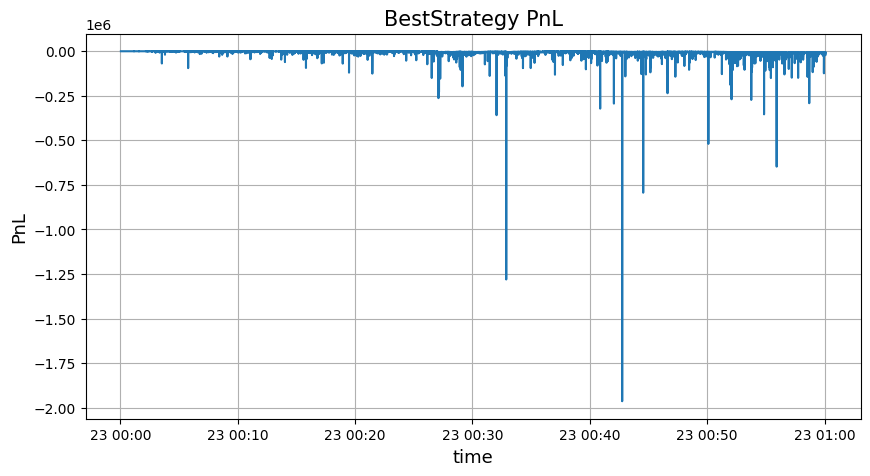

In [48]:
plt.figure(figsize=(10, 5))
plt.plot(dt, df.total, '-')
plt.xlabel("time", fontsize=13)
plt.ylabel("PnL", fontsize=13)
plt.title("BestStrategy PnL", fontsize=15)
plt.grid()
plt.show()

In [13]:
from simulator.simulator import Sim
from simulator.strategies.symetrical import Symetrical
from simulator.utils.get_info import get_pnl
from simulator.utils.load_data import merge_books_and_trades


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [14]:
from simulator.simulator import MdUpdate, OrderbookSnapshotUpdate, AnonTrade

from simulator.utils.get_info import md_to_dataframe, trade_to_dataframe


In [15]:
def generate_sample_data_1(n_points):
    '''
        this function generates market data with constant mid price and occasional trades
    '''
    mid_price = 100.0
    spread = 2.0
    bid_price = mid_price - spread / 2
    ask_price = mid_price + spread / 2
    size = 1
    
    books = [OrderbookSnapshotUpdate(2 * i, 2 * i, [(ask_price, size)], [(bid_price, size)]) for i in range(1) ]
    
    trades = []
    p = 0.25
    trade_id = np.random.choice([0, 1], size=n_points, p=[1-p, p])
    trade_id = [i % 5 == 0 for i in range(n_points)]
    for i in range(n_points):
        
        if trade_id[i]:
            
            side = np.random.choice([0, 1], size=1)[0]
            price = bid_price if side else ask_price
            side = "ASK" if side else "BID" 
            trade = AnonTrade(2 * i + 1, 2 * i + 1, side, size, price)
            trades.append(trade)

    return books, trades

In [16]:
def generate_sample_data_2(n_points):
    '''
        this function generates market data with lineary increasing mid price and 
        limit orders at the same distance from the mid price
    '''   
    mid_price = 100.0
    spread = 2.0
    bid_price = mid_price - spread / 2
    ask_price = mid_price + spread / 2
    size = 1
    
    books = []
    
    
    trades = []
    p = 0.5
    for i in range(n_points):
        
        bid_price = mid_price - spread / 2
        ask_price = mid_price + spread / 2
        
        book = OrderbookSnapshotUpdate(i, i, [(ask_price, size)], [(bid_price, size)])
        books.append( book  )
        mid_price += 1
    return books, trades

C:\Users\igorl\AppData\Local\Temp\ipykernel_20048\63827985.py:5: FutureWarning: Timedelta.delta is deprecated and will be removed in a future version.
  latency = pd.Timedelta(0, 'ns').delta
C:\Users\igorl\AppData\Local\Temp\ipykernel_20048\63827985.py:6: FutureWarning: Timedelta.delta is deprecated and will be removed in a future version.
  md_latency = pd.Timedelta(0, 'ns').delta
C:\Users\igorl\AppData\Local\Temp\ipykernel_20048\63827985.py:10: FutureWarning: Timedelta.delta is deprecated and will be removed in a future version.
  delay = pd.Timedelta(1, 'ns').delta
C:\Users\igorl\AppData\Local\Temp\ipykernel_20048\63827985.py:11: FutureWarning: Timedelta.delta is deprecated and will be removed in a future version.
  hold_time = pd.Timedelta(1000, 'ns').delta


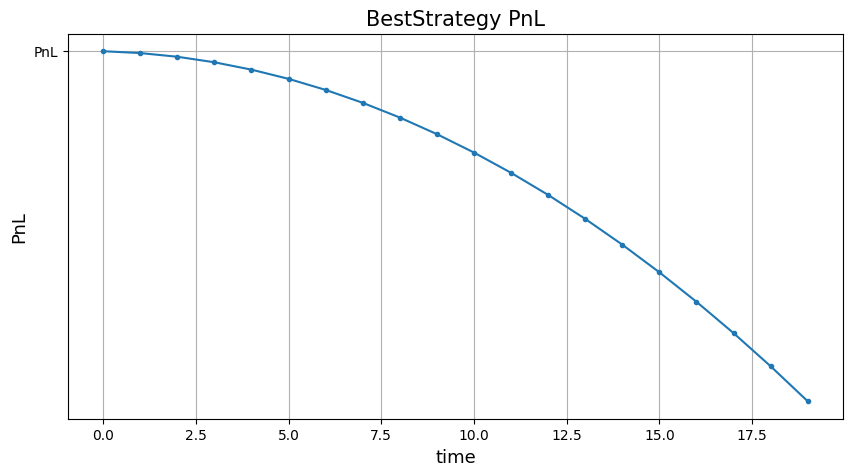

In [19]:
books, anon_trades = generate_sample_data_2(20)

md = merge_books_and_trades(books, anon_trades)

latency = pd.Timedelta(0, 'ns').delta
md_latency = pd.Timedelta(0, 'ns').delta
sim = Sim(md, latency, md_latency)

#delay between orders
delay = pd.Timedelta(1, 'ns').delta
hold_time = pd.Timedelta(1000, 'ns').delta
# strategy = Symetrical(delay, hold_time)
strategy = StoikovAvellaneda(delay, hold_time, gamma=0.5, sigma=0.05,
                             k=0.5, time_trading_session_ends=1655976252046013863)

own_trades, md_list, updates_list, all_orders = strategy.run(sim)

df_info = get_pnl(updates_list)
t = df_info.receive_ts.values

plt.figure(figsize=(10, 5))
plt.plot(t, df_info.total, '.-', 'PnL')
plt.xlabel("time", fontsize=13)
plt.ylabel("PnL", fontsize=13)

plt.title("BestStrategy PnL", fontsize=15)
plt.grid()
plt.show()

In [20]:
updates_list

[MdUpdate(exchange_ts=0, receive_ts=0, orderbook=OrderbookSnapshotUpdate(exchange_ts=0, receive_ts=0, asks=[(101.0, 1)], bids=[(99.0, 1)]), trade=None),
 MdUpdate(exchange_ts=1, receive_ts=1, orderbook=OrderbookSnapshotUpdate(exchange_ts=1, receive_ts=1, asks=[(102.0, 1)], bids=[(100.0, 1)]), trade=None),
 OwnTrade(place_ts=1, exchange_ts=1, receive_ts=1, trade_id=0, order_id=3, side='ASK', size=0.001, price=100.0, execute='BOOK'),
 MdUpdate(exchange_ts=2, receive_ts=2, orderbook=OrderbookSnapshotUpdate(exchange_ts=2, receive_ts=2, asks=[(103.0, 1)], bids=[(101.0, 1)]), trade=None),
 OwnTrade(place_ts=2, exchange_ts=2, receive_ts=2, trade_id=1, order_id=5, side='ASK', size=0.001, price=101.0, execute='BOOK'),
 MdUpdate(exchange_ts=3, receive_ts=3, orderbook=OrderbookSnapshotUpdate(exchange_ts=3, receive_ts=3, asks=[(104.0, 1)], bids=[(102.0, 1)]), trade=None),
 OwnTrade(place_ts=3, exchange_ts=3, receive_ts=3, trade_id=2, order_id=7, side='ASK', size=0.001, price=102.0, execute='BOOK')

In [21]:
all_orders

[Order(place_ts=0, exchange_ts=0, order_id=0, side='BID', size=0.001, price=-1034985157528660.2),
 Order(place_ts=0, exchange_ts=0, order_id=1, side='ASK', size=0.001, price=1034985157528860.2),
 Order(place_ts=1, exchange_ts=1, order_id=2, side='BID', size=0.001, price=-5174925787643695.0),
 Order(place_ts=1, exchange_ts=1, order_id=3, side='ASK', size=0.001, price=-3104955472586174.0),
 Order(place_ts=2, exchange_ts=2, order_id=4, side='BID', size=0.001, price=-7244896102701212.0),
 Order(place_ts=2, exchange_ts=2, order_id=5, side='ASK', size=0.001, price=-5174925787643692.0),
 Order(place_ts=3, exchange_ts=3, order_id=6, side='BID', size=0.001, price=-9314866417758728.0),
 Order(place_ts=3, exchange_ts=3, order_id=7, side='ASK', size=0.001, price=-7244896102701208.0),
 Order(place_ts=4, exchange_ts=4, order_id=8, side='BID', size=0.001, price=-1.1384836732816246e+16),
 Order(place_ts=4, exchange_ts=4, order_id=9, side='ASK', size=0.001, price=-9314866417758726.0),
 Order(place_ts=5

In [22]:
sim.ready_to_execute_orders

{0: Order(place_ts=0, exchange_ts=0, order_id=0, side='BID', size=0.001, price=-1034985157528660.2),
 1: Order(place_ts=0, exchange_ts=0, order_id=1, side='ASK', size=0.001, price=1034985157528860.2),
 2: Order(place_ts=1, exchange_ts=1, order_id=2, side='BID', size=0.001, price=-5174925787643695.0),
 4: Order(place_ts=2, exchange_ts=2, order_id=4, side='BID', size=0.001, price=-7244896102701212.0),
 6: Order(place_ts=3, exchange_ts=3, order_id=6, side='BID', size=0.001, price=-9314866417758728.0),
 8: Order(place_ts=4, exchange_ts=4, order_id=8, side='BID', size=0.001, price=-1.1384836732816246e+16),
 10: Order(place_ts=5, exchange_ts=5, order_id=10, side='BID', size=0.001, price=-1.3454807047873764e+16),
 12: Order(place_ts=6, exchange_ts=6, order_id=12, side='BID', size=0.001, price=-1.5524777362931278e+16),
 14: Order(place_ts=7, exchange_ts=7, order_id=14, side='BID', size=0.001, price=-1.7594747677988796e+16),
 16: Order(place_ts=8, exchange_ts=8, order_id=16, side='BID', size=0.